In [1]:
# LIBRARY
# vector manipulation
import numpy as np
import math 

# THIS IS FOR PLOTTING
get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib.pyplot as plt # side-stepping mpl backend
import warnings
warnings.filterwarnings("ignore")
from IPython.display import HTML
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib.ticker import LinearLocator
import matplotlib.pyplot as plt

from scipy.sparse import csc_matrix
from scipy.sparse.linalg import lsqr

In [2]:
def make_grid(N):

    x = np.linspace(0, 1, N, endpoint=True)    # make sure N grid points and last one is at 1.0
    y = np.linspace(0, 1, N, endpoint=True)    # make sure N grid points and last one is at 1.0

    h = x[1] - x[0]

    X, Y = np.meshgrid(x, y[::-1])
    
    fig = plt.figure()

    # plt.plot(x[1],y[1],'ro',label='unknown');
    plt.plot(X[1:-1,1:-1], Y[1:-1,1:-1], 'ro');

    plt.plot(np.ones(N), y, 'go', label='Boundary Condition');
    plt.plot(np.zeros(N), y, 'go');
    plt.plot(x, np.zeros(N), 'go');
    plt.plot(x, np.ones(N), 'go');
    plt.xlim((-0.1,1.1))
    plt.ylim((-0.1,1.1))
    plt.xlabel('x')
    plt.ylabel('y')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(r'Discrete Grid $\Omega_h,$ h= %s'%(h),fontsize=24,y=1.08)
    plt.show()

    m = X.shape[1]
    
    coordinate = []
    
    for i in range(X.shape[0]):
        for j in range(Y.shape[0]):
            c = np.array([X[i,j], Y[i,j]], dtype=np.float32)
            coordinate.append(c)
    
    return x,y,X,Y,h,coordinate

In [3]:
def source(CHOICE,X,Y,N):
    
    if CHOICE == 'X+Y':
        T_b = X+Y
        f = np.zeros((N-2)**2)
    
    elif CHOICE == 'cos(Pi*X)':
        T_b = np.cos(np.pi*X)
        f = -np.pi**2*np.cos(np.pi*X[1:N-1,1:N-1]).reshape(-1,1)

    elif CHOICE == 'sin(Pi*X)':
        T_b = np.sin(np.pi*X)
        f = -np.pi**2*np.sin(np.pi*X[1:N-1,1:N-1]).reshape(-1,1)

    elif CHOICE == 'sin(Pi*X)+sin(Pi*Y)':
        T_b = np.sin(np.pi*X)+np.sin(np.pi*Y)
        f = -np.pi**2*np.sin(np.pi*X[1:N-1,1:N-1]).reshape(-1,1) - np.pi**2*np.sin(np.pi*Y[1:N-1,1:N-1]).reshape(-1,1)

    elif CHOICE == 'cos(Pi*X)+cos(Pi*Y)':
        T_b = np.cos(np.pi*X)+np.cos(np.pi*Y)
        f = -np.pi**2*np.cos(np.pi*X[1:N-1,1:N-1]).reshape(-1,1) -np.pi**2*np.cos(np.pi*Y[1:N-1,1:N-1]).reshape(-1,1)

    elif CHOICE == 'X*Y':
        T_b = X*Y
        f = np.zeros((N-2)**2)

    elif CHOICE == 'cos(Pi*X)*sin(Pi*Y)':
        T_b = np.cos(np.pi*X)*np.sin(np.pi*Y)
        f = -2*np.pi**2*np.cos(np.pi*X[1:N-1,1:N-1])*np.sin(np.pi*Y[1:N-1,1:N-1])
        f = f.reshape(-1,1)

    else:
        raise NotImplementedError("wrong CHOICE")
        
    return f, T_b

In [4]:
def set_boundary(w,T_b):

    w[0, :] = T_b[0, 1:-1]     # top
    w[-1, :] = T_b[-1, 1:-1]   # bottom
    w[:, 0] = T_b[1:-1, 0]     # left
    w[:, -1] = T_b[1:-1, -1]   # right
    
    return w

In [5]:
def plot_boundary(X,Y,w):
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    # Plot a basic wireframe.
    ax.plot_wireframe(X[1:-1,1:-1], Y[1:-1,1:-1], w, color='r', rstride=10, cstride=10)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('u')
    plt.title(r'Boundary Values',fontsize=24,y=1.08)
    plt.show()

## write an index function that converts i,j to s

## and funtions from s to i,j

In [6]:
def S(i,j,N):
    return (i-1)*(N-2) + j-1

def Sinv(s,N):
    j = s % (N-2) + 1
    i = 1+(s - (j - 1))//(N-2)
    return i,j

## First, let's setup the coefficients for interior points -- those won't interact with boundary

In [7]:
def set_interior_nodes(A,N,h):

    for i in range(2,N-2):
        for j in range(2,N-2):
            # print(i,j)

            A[S(i,j,N), S(i+1,j,N)] = 1/h**2 # the one below
            A[S(i,j,N), S(i-1,j,N)] = 1/h**2 # the one above
            A[S(i,j,N), S(i,j,N)]  = -4/h**2 
            A[S(i,j,N), S(i,j+1,N)] = 1/h**2 # the one to the right
            A[S(i,j,N), S(i,j-1,N)] = 1/h**2 # the one to the left
            
    return A

## Second, lets find out coefficient for things on the top boundary (not the corners)

In [8]:
def set_top_boundary(A,N,h,b,T_b):
    
    for i in [1]:
        for j in range(2,N-2):
            # print(i,j)

            A[S(i,j,N), S(i+1,j,N)] = 1/h**2 # the one below
            # A[S(i,j), S(i-1,j)] = 1/h**2 # the one above
            A[S(i,j,N), S(i,j,N)]  = -4/h**2 
            A[S(i,j,N), S(i,j+1,N)] = 1/h**2 # the one to the right
            A[S(i,j,N), S(i,j-1,N)] = 1/h**2 # the one to the left

            # now the top one will have the boundary forcing acting on (i,j) element
            #print('A is: ',A)
            b[S(i,j,N)] += -1/h**2 * T_b[i-1,j] 
            #print('b is: ',b)
            
    return A,b

## then bottom boundary

In [9]:
def set_bottom_boundary(A,N,h,b,T_b):
    
    for i in [N-2]:
        for j in range(2,N-2):
            # print(i,j)

            # A[S(i,j), S(i+1,j)] = 1/h**2 # the one below
            A[S(i,j,N), S(i-1,j,N)] = 1/h**2 # the one above
            A[S(i,j,N), S(i,j,N)]  = -4/h**2 
            A[S(i,j,N), S(i,j+1,N)] = 1/h**2 # the one to the right
            A[S(i,j,N), S(i,j-1,N)] = 1/h**2 # the one to the left

            # now the below one will have the boundary acting on (i,j) element
            b[S(i,j,N)] += -1/h**2 * T_b[i+1,j] 
            
    return A,b

## left boundary

In [10]:
def set_left_boundary(A,N,h,b,T_b):
    
    for j in [1]:
        for i in range(2,N-2):
            # print(i,j)

            A[S(i,j,N), S(i+1,j,N)] = 1/h**2 # the one below
            A[S(i,j,N), S(i-1,j,N)] = 1/h**2 # the one above
            A[S(i,j,N), S(i,j,N)]  = -4/h**2 
            A[S(i,j,N), S(i,j+1,N)] = 1/h**2 # the one to the right
            # A[S(i,j), S(i,j-1)] = 1/h**2 # the one to the left

            # now the left one will have the boundary acting on (i,j) element
            b[S(i,j,N)] += -1/h**2 * T_b[i,j-1] 
            
    return A,b

## right boundary

In [11]:
def set_right_boundary(A,N,h,b,T_b):
    
    for j in [N-2]:
        for i in range(2,N-2):
            # print(i,j)

            A[S(i,j,N), S(i+1,j,N)] = 1/h**2 # the one below
            A[S(i,j,N), S(i-1,j,N)] = 1/h**2 # the one above
            A[S(i,j,N), S(i,j,N)]  = -4/h**2 
            # A[S(i,j), S(i,j+1)] = 1/h**2 # the one to the right
            A[S(i,j,N), S(i,j-1,N)] = 1/h**2 # the one to the left

            # now the right one will have the boundary acting on (i,j) element
            b[S(i,j,N)] += -1/h**2 * T_b[i,j+1] 
            
    return A,b

## four corners

In [12]:
def set_corners(A,N,h,b,T_b):
    
    ### top left
    i = 1; j = 1

    A[S(i,j,N), S(i+1,j,N)] = 1/h**2 # the one below
    # A[S(i,j), S(i-1,j)] = 1/h**2 # the one above
    A[S(i,j,N), S(i,j,N)]  = -4/h**2 
    A[S(i,j,N), S(i,j+1,N)] = 1/h**2 # the one to the right
    # A[S(i,j), S(i,j-1)] = 1/h**2 # the one to the left

    # now the above the left ones will have the boundary acting on (i,j) element
    b[S(i,j,N)]+= -1/h**2 * T_b[i-1,j] 
    b[S(i,j,N)]+= -1/h**2 * T_b[i,j-1] 


    ### top right
    i = 1; j = N-2

    A[S(i,j,N), S(i+1,j,N)] = 1/h**2 # the one below
    # A[S(i,j), S(i-1,j)] = 1/h**2 # the one above
    A[S(i,j,N), S(i,j,N)]  = -4/h**2 
    # A[S(i,j), S(i,j+1)] = 1/h**2 # the one to the right
    A[S(i,j,N), S(i,j-1,N)] = 1/h**2 # the one to the left

    # now the above the left ones will have the boundary acting on (i,j) element
    b[S(i,j,N)]+= -1/h**2 * T_b[i-1,j] 
    b[S(i,j,N)]+= -1/h**2 * T_b[i,j+1] 


    ### bottom left
    i = N-2; j = 1

    # A[S(i,j), S(i+1,j)] = 1/h**2 # the one below
    A[S(i,j,N), S(i-1,j,N)] = 1/h**2 # the one above
    A[S(i,j,N), S(i,j,N)]  = -4/h**2 
    A[S(i,j,N), S(i,j+1,N)] = 1/h**2 # the one to the right
    # A[S(i,j), S(i,j-1)] = 1/h**2 # the one to the left

    # now the above the left ones will have the boundary acting on (i,j) element
    b[S(i,j,N)]+= -1/h**2 * T_b[i+1,j] 
    b[S(i,j,N)]+= -1/h**2 * T_b[i,j-1] 


    ### bottom right
    i = N-2; j = N-2

    # A[S(i,j), S(i+1,j)] = 1/h**2 # the one below
    A[S(i,j,N), S(i-1,j,N)] = 1/h**2 # the one above
    A[S(i,j,N), S(i,j,N)]  = -4/h**2 
    # A[S(i,j), S(i,j+1)] = 1/h**2 # the one to the right
    A[S(i,j,N), S(i,j-1,N)] = 1/h**2 # the one to the left

    # now the above the left ones will have the boundary acting on (i,j) element
    b[S(i,j,N)]+= -1/h**2 * T_b[i+1,j] 
    b[S(i,j,N)]+= -1/h**2 * T_b[i,j+1] 
    
    return A,b

# Finally, visualize the A and b

In [13]:
def plot_matrix(A,h,N,b):
    
    fig = plt.figure(figsize=(12,4));
    plt.subplot(121)
    plt.imshow(A, cmap='RdBu',vmin=-0.1/h**2,vmax=0.1/h**2);
    plt.show()

    plt.subplot(122)
    plt.imshow((b).reshape((N-2)**2,1),cmap='RdBu',vmin=-0.1/h**2,vmax=0.1/h**2);
    plt.show()

## Visualize $A^{-1}$

In [14]:
def plot_inverse(A_inv,h):
    
    A_inv = np.linalg.inv(A)
    plt.imshow(A_inv,cmap='RdBu',vmax=0.1*h**2,vmin=-0.1*h**2);
    plt.show()

## Solve Ax=b and rearrange them into a 2D matrix

In [15]:
def solve(A,b,h,T_b,N):
    
    #T_s_1d = np.linalg.lstsq(A*h**2,b*h**2)[0]
    T_s_1d = lsqr(A*h**2,b*h**2)[0]

    T_s = np.copy(T_b)
    for s in range(len(T_s_1d)):
        # print(s)
        i,j = Sinv(s,N)
        T_s[i,j] = T_s_1d[s]
        
    return T_s

## visualize the results

In [16]:
def plot_results(X,Y,T_b,T_s):
    
    fig = plt.figure(figsize=(8,4));
    plt.subplot(121)
    plt.pcolor(X,Y,T_b)
    plt.title('True')

    plt.subplot(122)
    plt.pcolor(X,Y,T_s)
    plt.title('FD')

# Error
$$
\sqrt{\int (T_b(x,y) - T_s(x,y))^2 dx dy} \approx \sqrt{\sum_{i,j} h^2 (T_b(x_i,y_j) - T_s(x_i,y_j))^2} = h \sqrt{\sum_{i,j} (T_b(x_i,y_j) - T_s(x_i,y_j))^2}
$$

In [17]:
def error(T_b,T_s,h):
    r = np.linalg.norm(T_b - T_s, ord='fro') * h
    return r

In [18]:
def main(min_N,max_N):
    errors = []
    i = 0
    
    for no_points in range(min_N,max_N,1):

        N = no_points
        
        # CHOICE = 'cos(Pi*X)'
        # CHOICE = 'sin(Pi*X)'
        # CHOICE = 'sin(Pi*X)+sin(Pi*Y)'
        # CHOICE = 'cos(Pi*X)+cos(Pi*Y)'
        # CHOICE = 'X*Y'   
        CHOICE = 'cos(Pi*X)*sin(Pi*Y)'

        x,y,X,Y,h,coordinate = make_grid(N)

        f,T_b = source(CHOICE,X,Y,N)

        w = np.zeros((N-2,N-2))  # here we only have N-2 unknowns

        #plot_boundary(X,Y,w)

        T_b.flatten()

        M = (N-2)*(N-2)

        A = np.zeros((M,M))

        b = f    #source term

        # initilaize matrix A
        A = set_interior_nodes(A,N,h)
        A,b = set_top_boundary(A,N,h,b,T_b)
        A,b = set_bottom_boundary(A,N,h,b,T_b)
        A,b = set_left_boundary(A,N,h,b,T_b)
        A,b = set_right_boundary(A,N,h,b,T_b)
        A,b = set_corners(A,N,h,b,T_b)
        
        sA = csc_matrix(A)

        #plot_matrix(A,h,N,b)
        #A_inv = spsolve(A)
        
        #plot_inverse(A_inv,h)
        T_s = solve(sA,b,h,T_b,N)
        #plot_results(X,Y,T_b,T_s)
        err = error(T_b,T_s,h)
        h_p = "{:.5f}".format(h)
        print(f'N = {no_points}, h = {h_p} ---->  error = {err}')
        errors.append(err)
        
        
        if i == 0:
            tmp1 = np.array(coordinate)
            coordinates = tmp1
            tmp2 = T_s.flatten()
            labels = tmp2
            
        else:
            coordinates = np.append(coordinates, coordinate, axis=0)
            label = T_s.flatten()
            labels = np.append(labels, label, axis=0)
           
        i+=1

    
    dim_coor = coordinates.shape[0]
    labels = np.reshape(labels, (dim_coor,1))
    #print('feature: ', coordinates)
    #print('label:', labels)
        
    plt.figure(figsize=(8,8))

    plt.plot(errors)
    plt.title('Error vs Grid dimension')
    plt.ylabel('error')
    plt.xlabel('# grid dimension (N)')
    plt.yscale("log") 
    plt.xscale("log") 
    plt.grid()
    plt.savefig('error')
    
    return A,b,coordinates,errors,labels

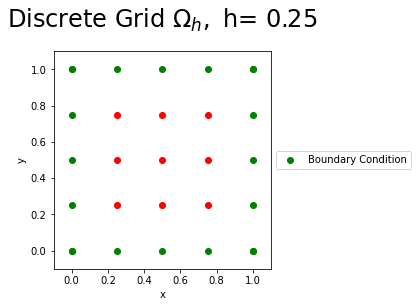

N = 5, h = 0.25000 ---->  error = 0.00849468841846562


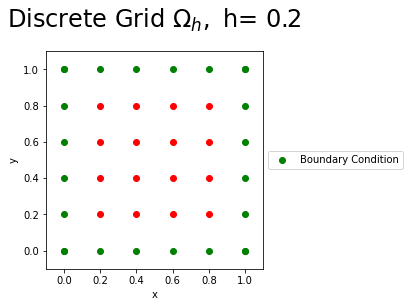

N = 6, h = 0.20000 ---->  error = 0.005548493973057103


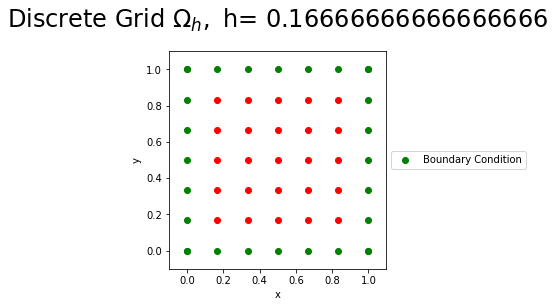

N = 7, h = 0.16667 ---->  error = 0.003881293068467036


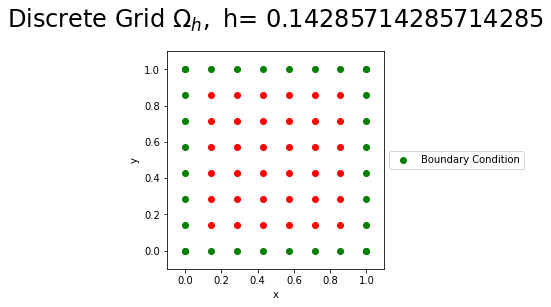

N = 8, h = 0.14286 ---->  error = 0.0028605314826323906


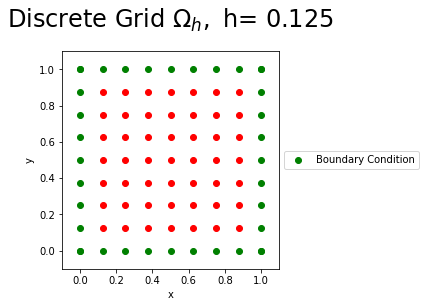

N = 9, h = 0.12500 ---->  error = 0.002193459315132806


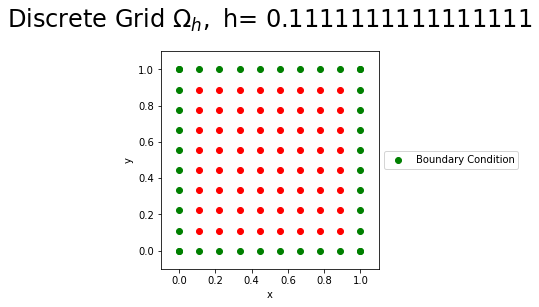

N = 10, h = 0.11111 ---->  error = 0.0017345303949222964


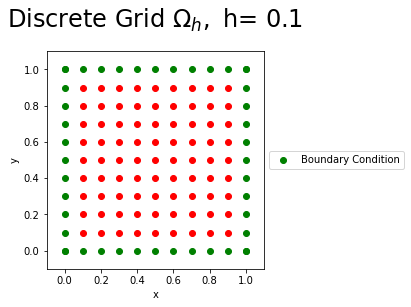

N = 11, h = 0.10000 ---->  error = 0.0014056349480316343


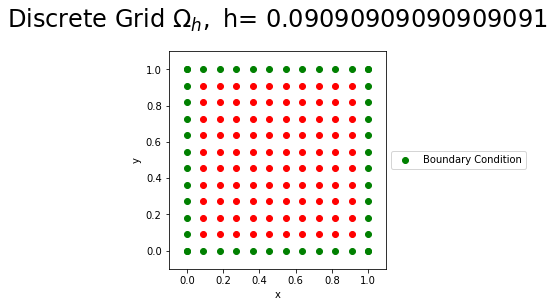

N = 12, h = 0.09091 ---->  error = 0.0011620166080231348


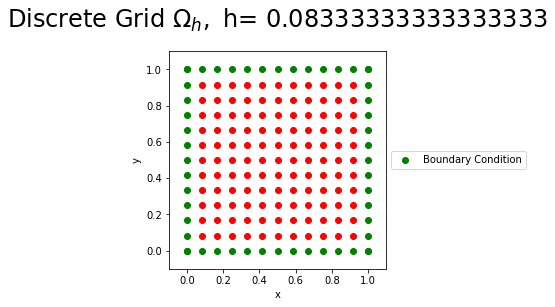

N = 13, h = 0.08333 ---->  error = 0.0009765961073653772


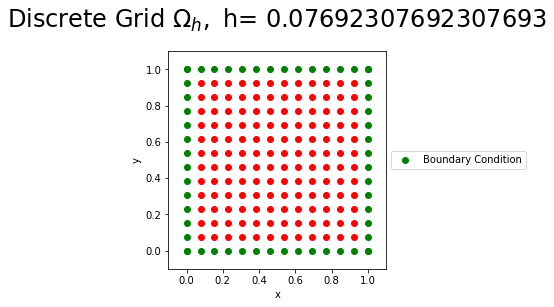

N = 14, h = 0.07692 ---->  error = 0.0008322304701915821


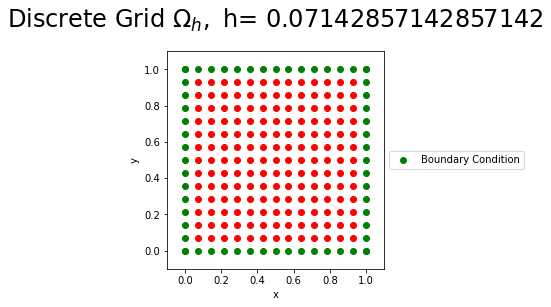

N = 15, h = 0.07143 ---->  error = 0.0007176462075666651


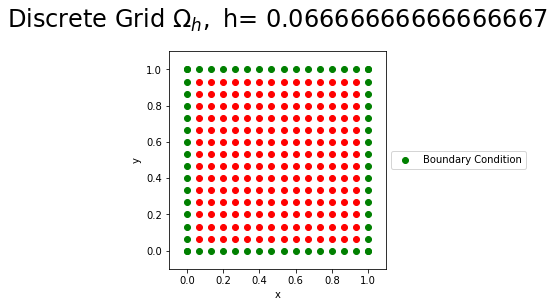

N = 16, h = 0.06667 ---->  error = 0.000625186191639797


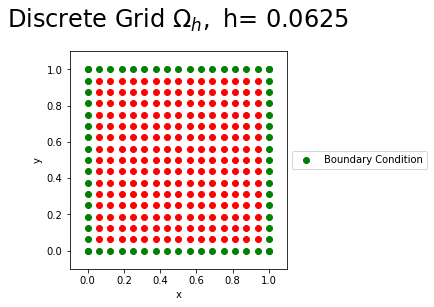

N = 17, h = 0.06250 ---->  error = 0.0005495032397102461


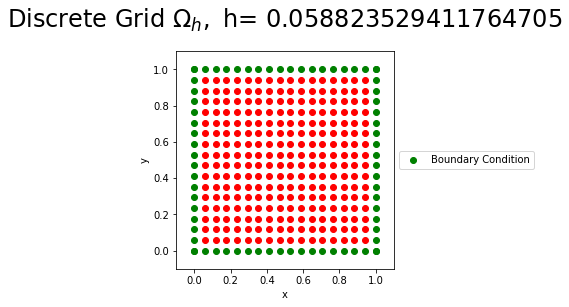

N = 18, h = 0.05882 ---->  error = 0.00048677231596001743


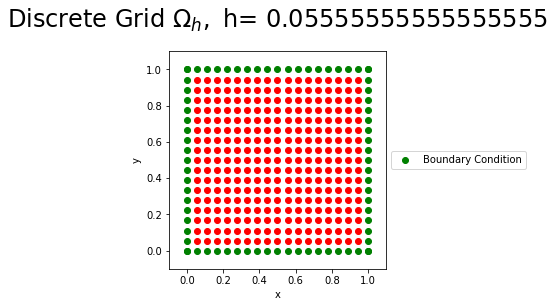

N = 19, h = 0.05556 ---->  error = 0.0004341990030980757


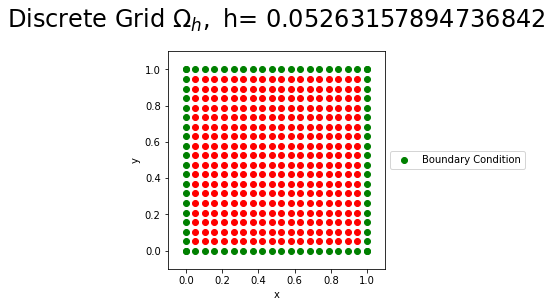

N = 20, h = 0.05263 ---->  error = 0.0003897035366576677


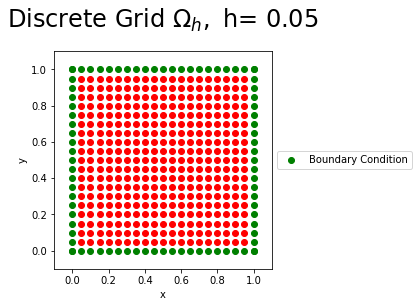

N = 21, h = 0.05000 ---->  error = 0.0003517122790705105


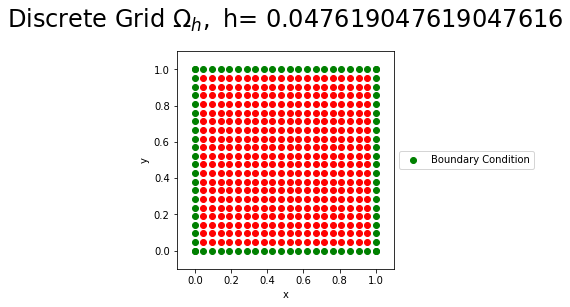

N = 22, h = 0.04762 ---->  error = 0.000319016848244371


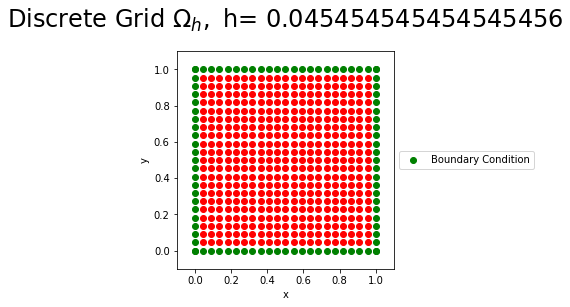

N = 23, h = 0.04545 ---->  error = 0.0002906769340110443


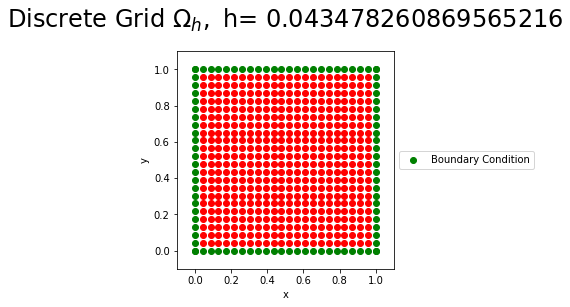

N = 24, h = 0.04348 ---->  error = 0.0002659519925915945


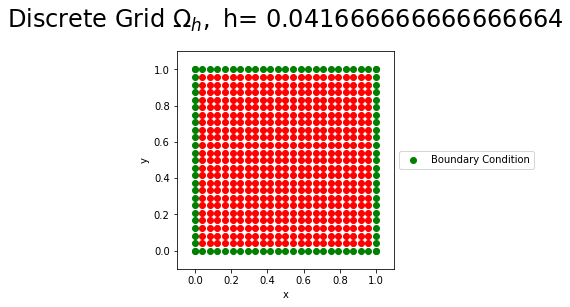

N = 25, h = 0.04167 ---->  error = 0.0002442524134428143


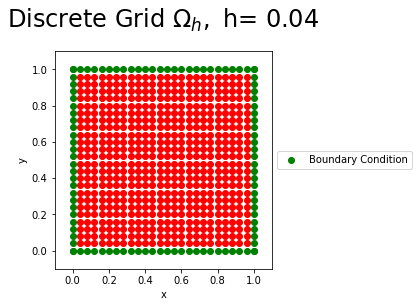

N = 26, h = 0.04000 ---->  error = 0.0002251040531062662


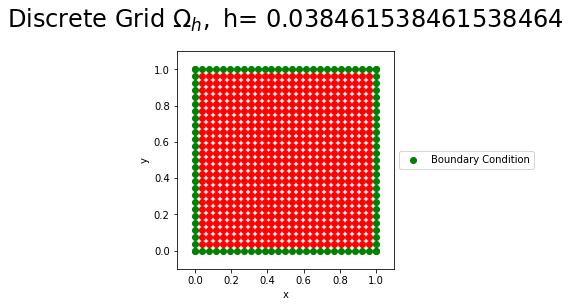

N = 27, h = 0.03846 ---->  error = 0.00020812213785188343


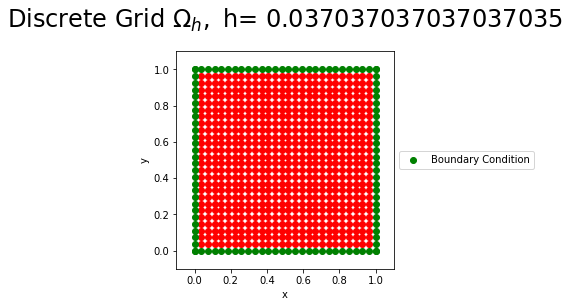

N = 28, h = 0.03704 ---->  error = 0.00019299177571506935


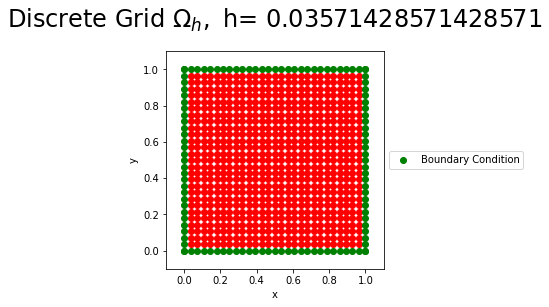

N = 29, h = 0.03571 ---->  error = 0.00017945328759427312


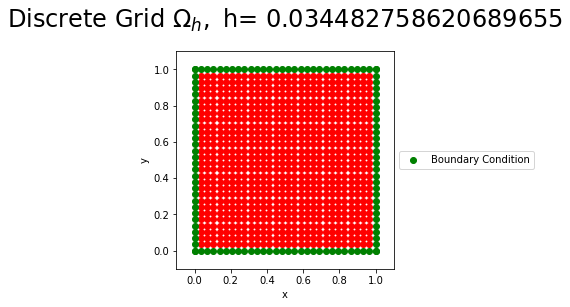

N = 30, h = 0.03448 ---->  error = 0.00016729095108344036


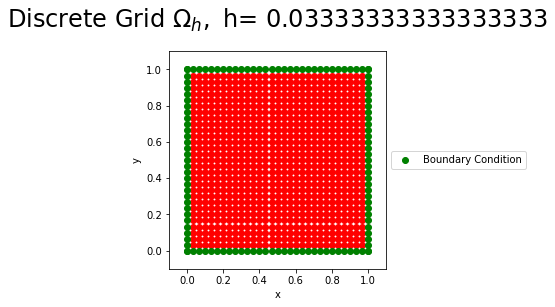

N = 31, h = 0.03333 ---->  error = 0.00015632438686365014


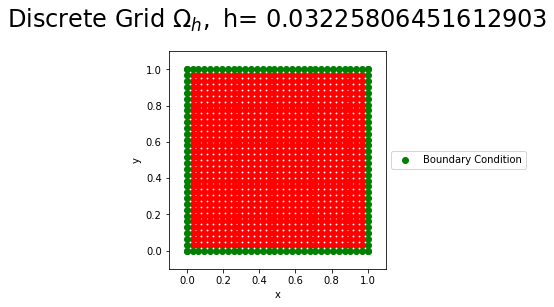

N = 32, h = 0.03226 ---->  error = 0.00014640185826622013


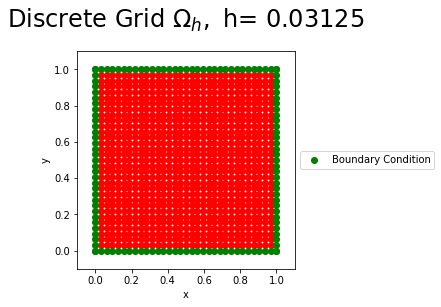

N = 33, h = 0.03125 ---->  error = 0.00013739490410133044


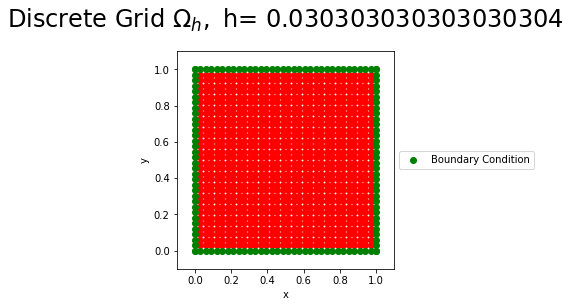

N = 34, h = 0.03030 ---->  error = 0.00012919425397428663


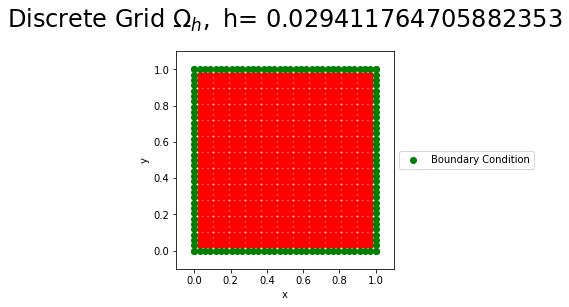

N = 35, h = 0.02941 ---->  error = 0.0001217064690564808


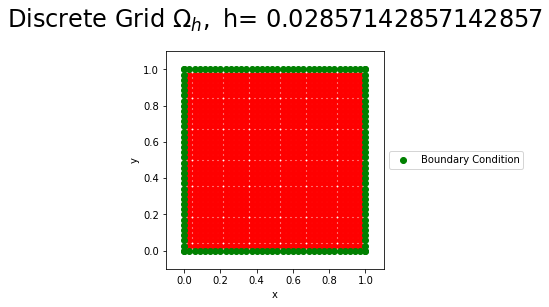

N = 36, h = 0.02857 ---->  error = 0.0001148512546993726


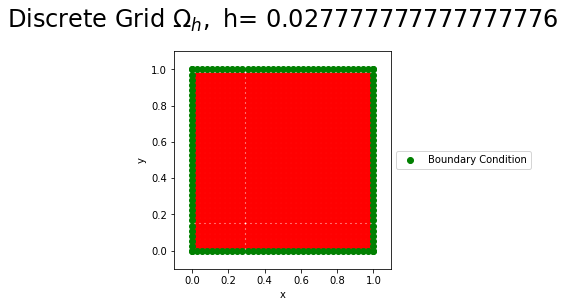

N = 37, h = 0.02778 ---->  error = 0.00010855936440795391


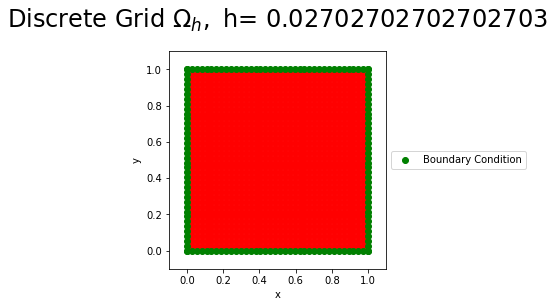

N = 38, h = 0.02703 ---->  error = 0.00010277066079757731


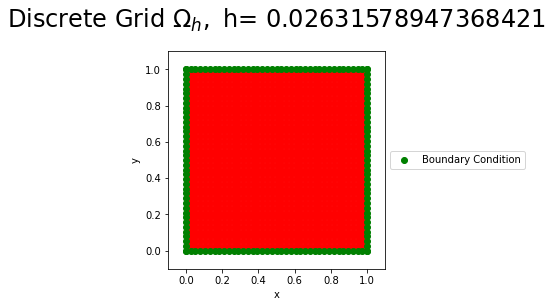

N = 39, h = 0.02632 ---->  error = 9.743289579807542e-05


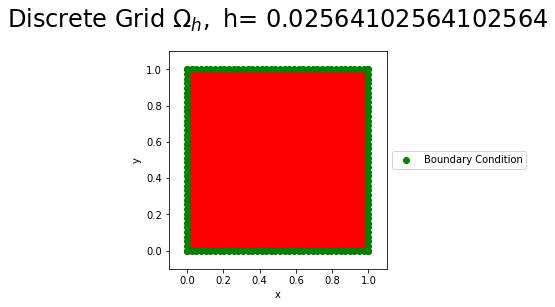

N = 40, h = 0.02564 ---->  error = 9.250043942341024e-05


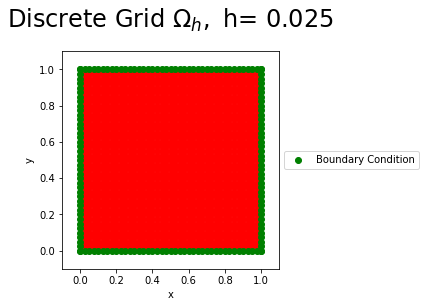

N = 41, h = 0.02500 ---->  error = 8.793323043151594e-05


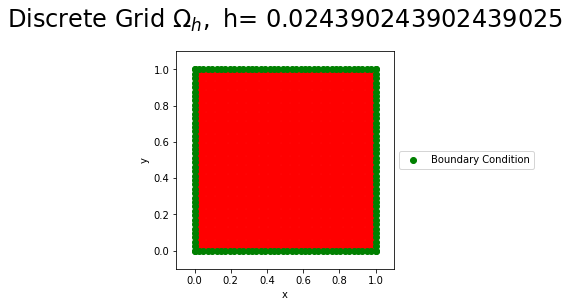

N = 42, h = 0.02439 ---->  error = 8.369620474995685e-05


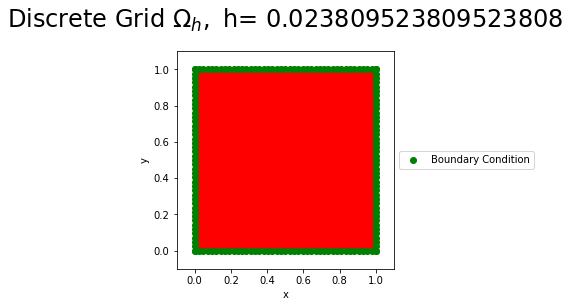

N = 43, h = 0.02381 ---->  error = 7.975812676263376e-05


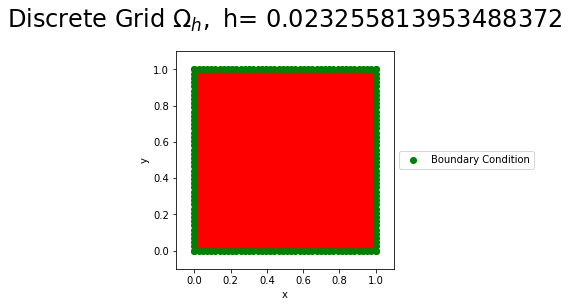

N = 44, h = 0.02326 ---->  error = 7.609159327425932e-05


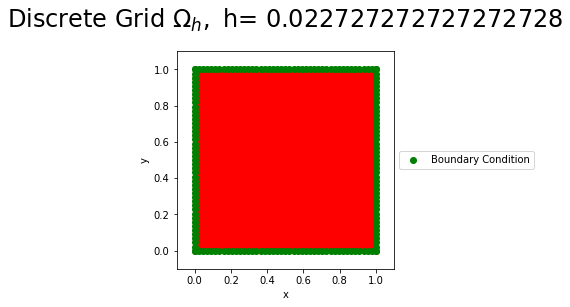

N = 45, h = 0.02273 ---->  error = 7.267214029989437e-05


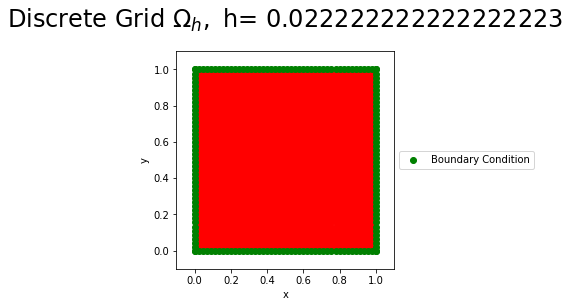

N = 46, h = 0.02222 ---->  error = 6.947818833262365e-05


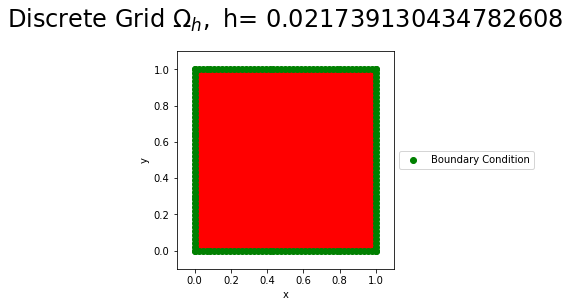

N = 47, h = 0.02174 ---->  error = 6.649029271169488e-05


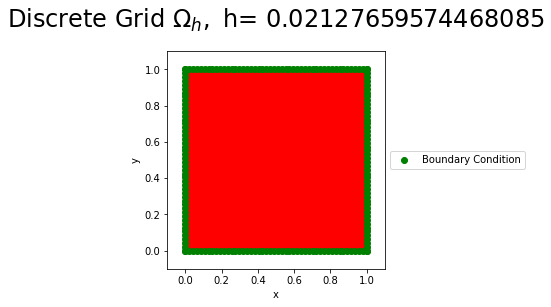

N = 48, h = 0.02128 ---->  error = 6.3691009912313e-05


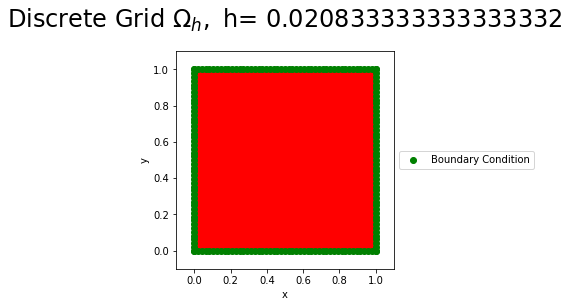

N = 49, h = 0.02083 ---->  error = 6.106489696117016e-05


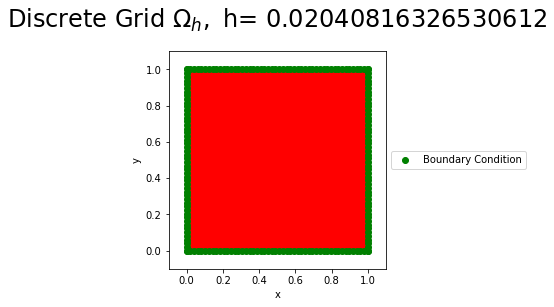

N = 50, h = 0.02041 ---->  error = 5.859780735301562e-05


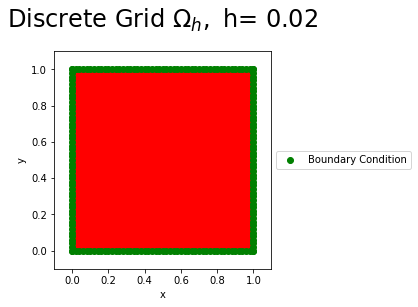

N = 51, h = 0.02000 ---->  error = 5.627733722533924e-05


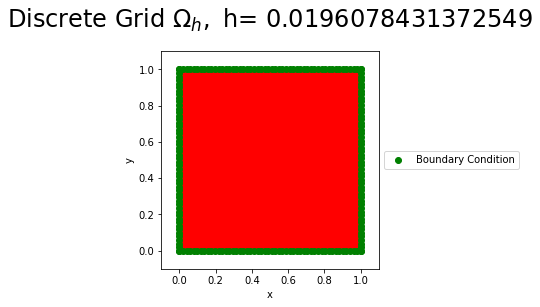

N = 52, h = 0.01961 ---->  error = 5.409189811629532e-05


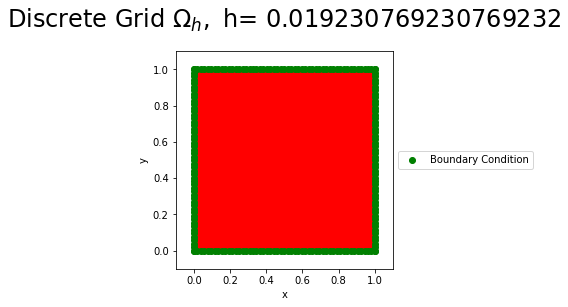

N = 53, h = 0.01923 ---->  error = 5.2031424642298555e-05


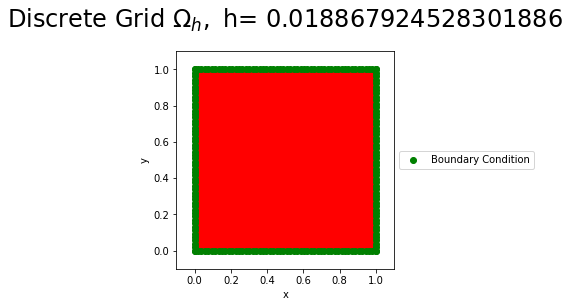

N = 54, h = 0.01887 ---->  error = 5.0086419620729265e-05


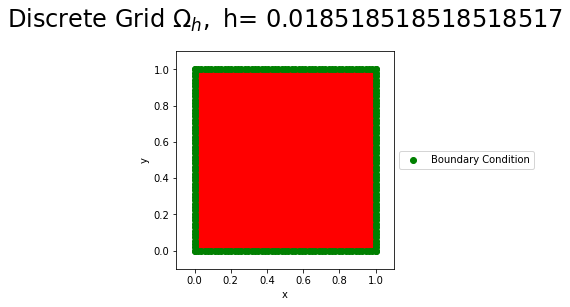

N = 55, h = 0.01852 ---->  error = 4.824851513029686e-05


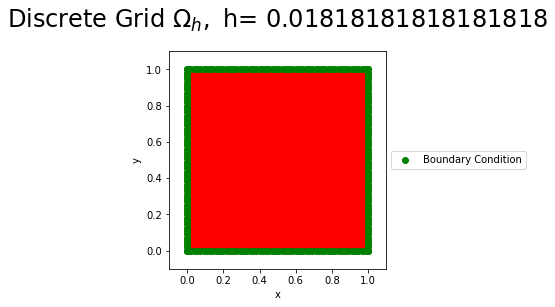

N = 56, h = 0.01818 ---->  error = 4.6509904042575885e-05


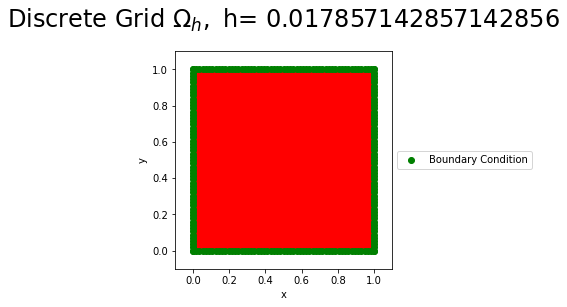

N = 57, h = 0.01786 ---->  error = 4.486390186903842e-05


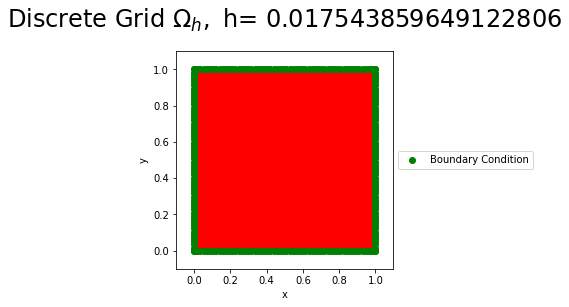

N = 58, h = 0.01754 ---->  error = 4.3303473706726265e-05


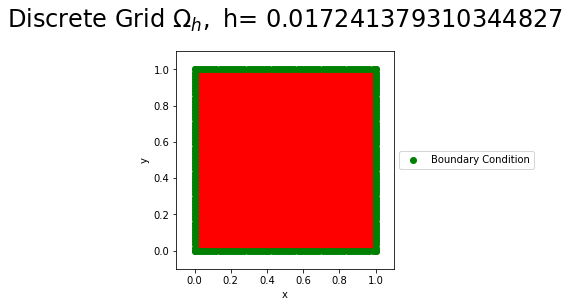

N = 59, h = 0.01724 ---->  error = 4.182279469820881e-05


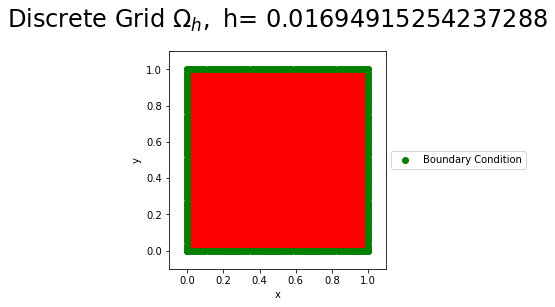

N = 60, h = 0.01695 ---->  error = 4.041738200599194e-05


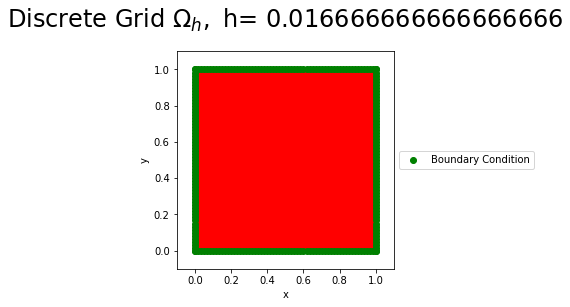

N = 61, h = 0.01667 ---->  error = 3.9081381623712876e-05


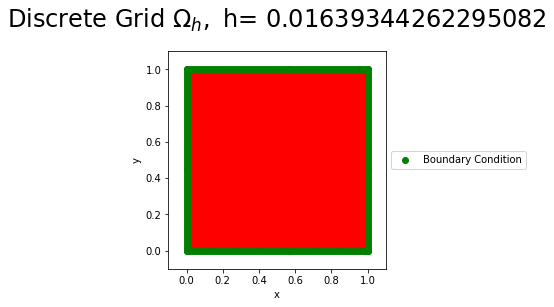

N = 62, h = 0.01639 ---->  error = 3.781019412014756e-05


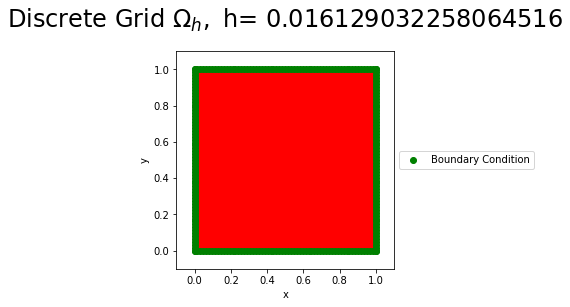

N = 63, h = 0.01613 ---->  error = 3.660026393000216e-05


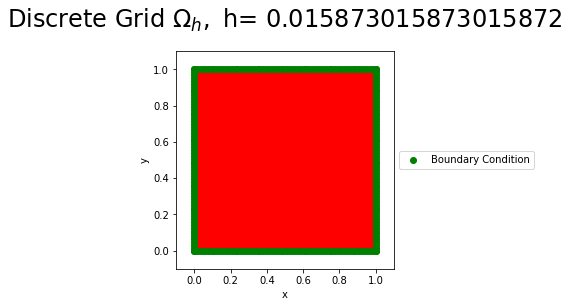

N = 64, h = 0.01587 ---->  error = 3.544751808570526e-05


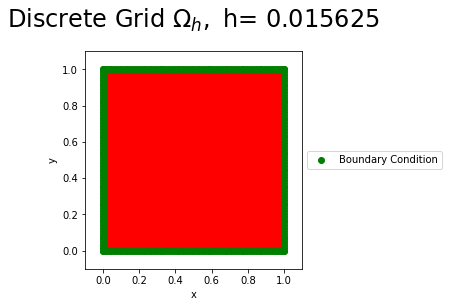

N = 65, h = 0.01562 ---->  error = 3.434837670388092e-05


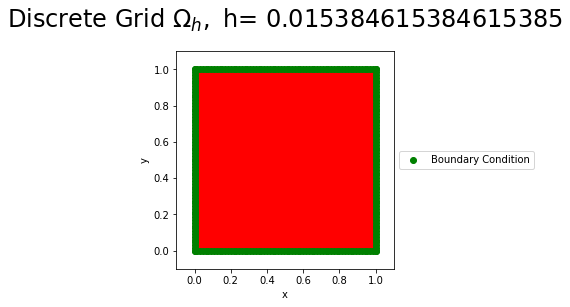

N = 66, h = 0.01538 ---->  error = 3.329965894790546e-05


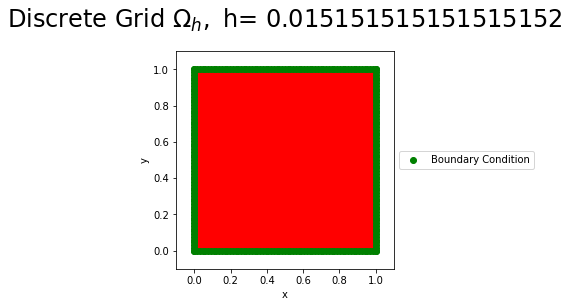

N = 67, h = 0.01515 ---->  error = 3.229782002591396e-05


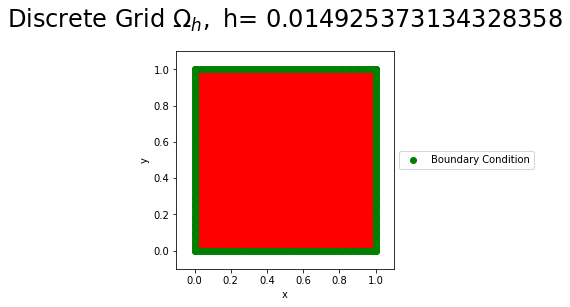

N = 68, h = 0.01493 ---->  error = 3.134131982901017e-05


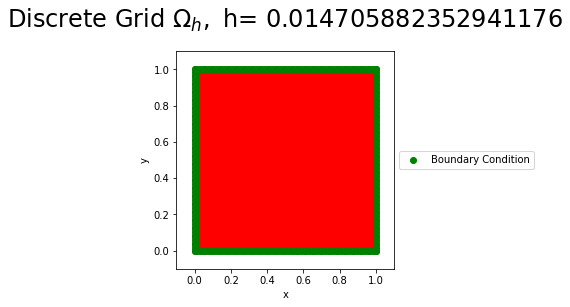

N = 69, h = 0.01471 ---->  error = 3.0425713622942827e-05


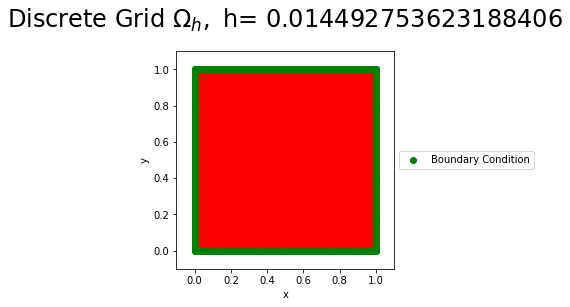

N = 70, h = 0.01449 ---->  error = 2.954997275295104e-05


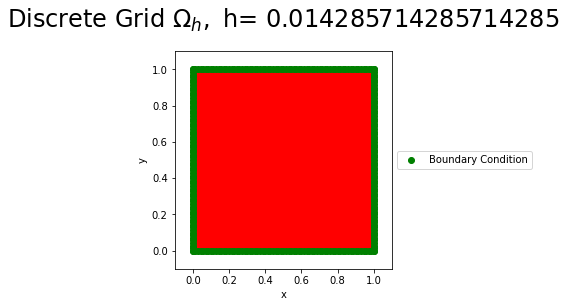

N = 71, h = 0.01429 ---->  error = 2.8711585042450795e-05


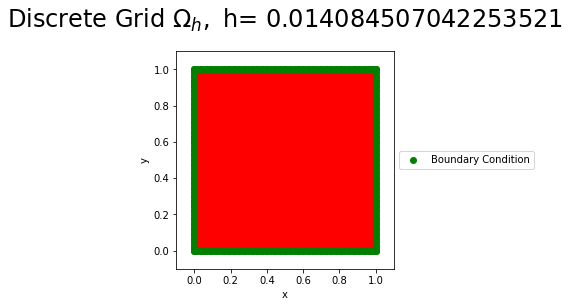

N = 72, h = 0.01408 ---->  error = 2.7909031029227097e-05


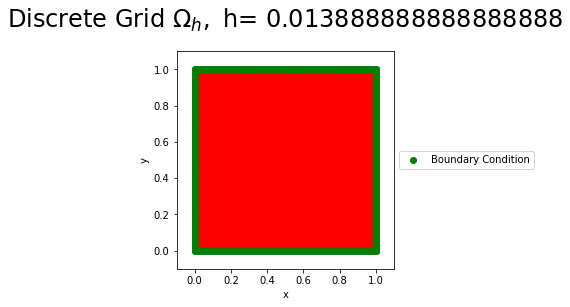

N = 73, h = 0.01389 ---->  error = 2.713849288132019e-05


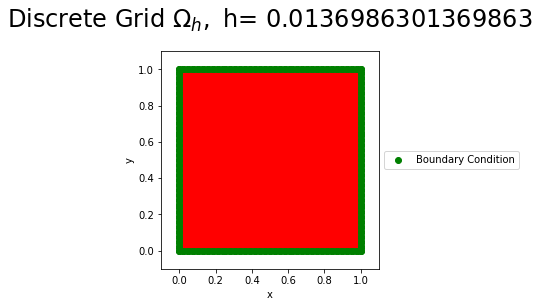

N = 74, h = 0.01370 ---->  error = 2.640021434451195e-05


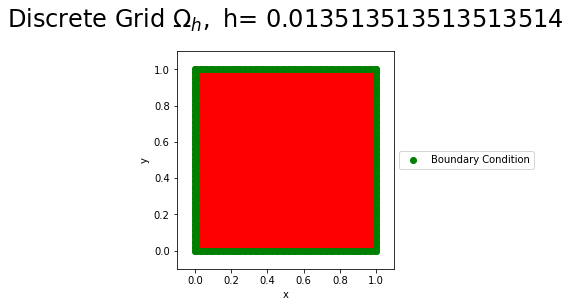

N = 75, h = 0.01351 ---->  error = 2.5691306548571505e-05


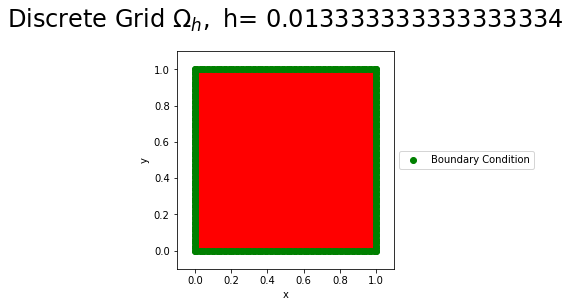

N = 76, h = 0.01333 ---->  error = 2.501018276563942e-05


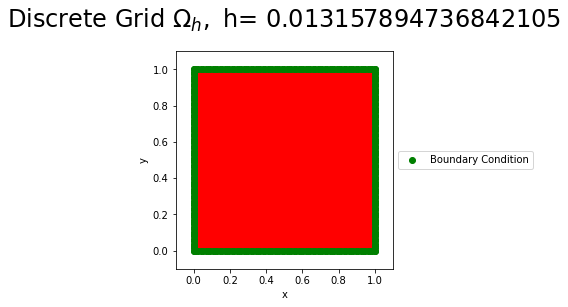

N = 77, h = 0.01316 ---->  error = 2.4356619310831485e-05


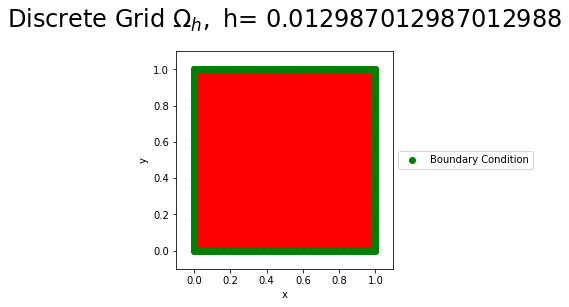

N = 78, h = 0.01299 ---->  error = 2.37284808218834e-05


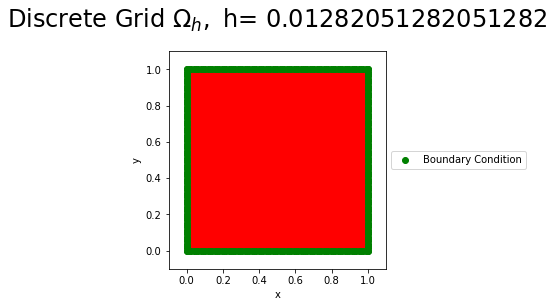

N = 79, h = 0.01282 ---->  error = 2.3123380066604252e-05


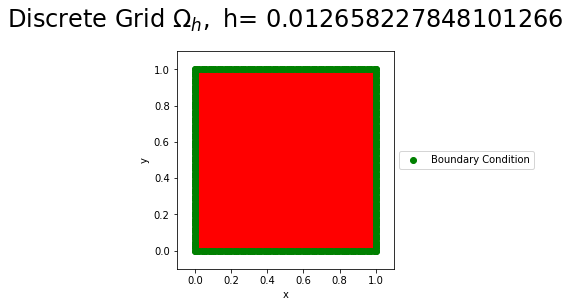

N = 80, h = 0.01266 ---->  error = 2.2540858427448504e-05


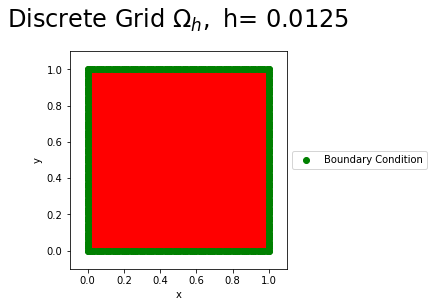

N = 81, h = 0.01250 ---->  error = 2.198103499908427e-05


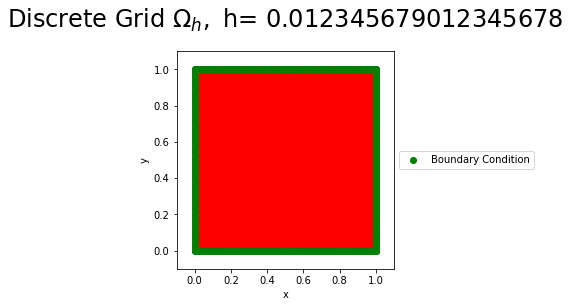

N = 82, h = 0.01235 ---->  error = 2.1440835437508386e-05


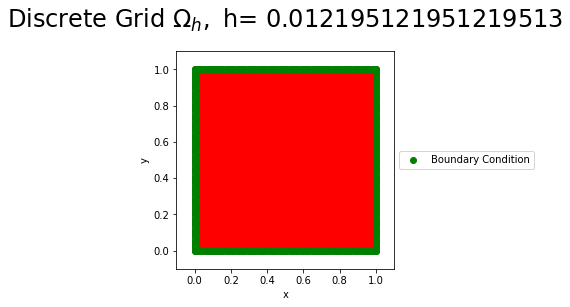

N = 83, h = 0.01220 ---->  error = 2.0920157780473622e-05


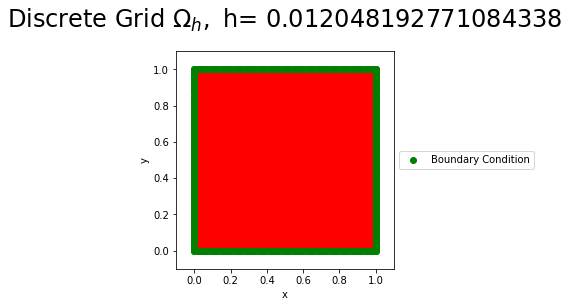

N = 84, h = 0.01205 ---->  error = 2.042005092100978e-05


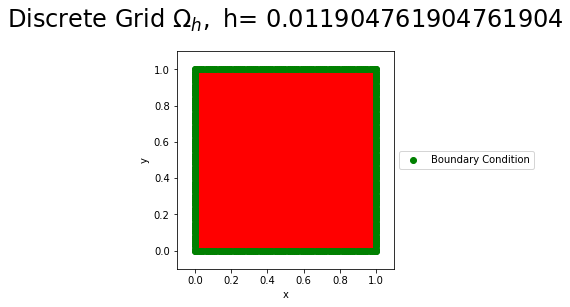

N = 85, h = 0.01190 ---->  error = 1.993536768430198e-05


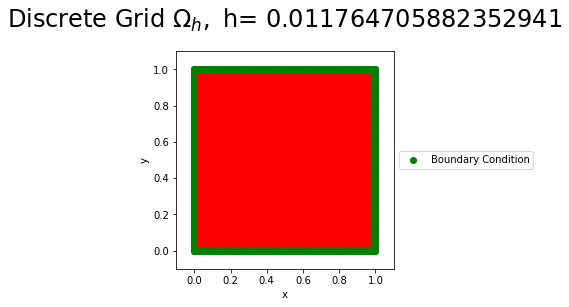

N = 86, h = 0.01176 ---->  error = 1.9469895970167327e-05


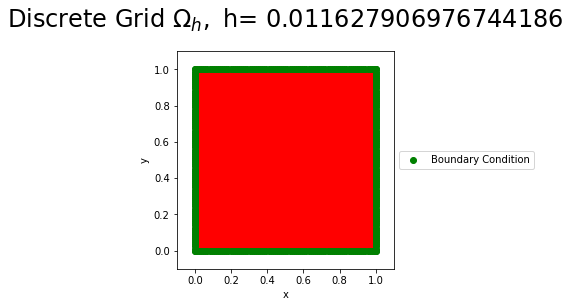

N = 87, h = 0.01163 ---->  error = 1.901982550931825e-05


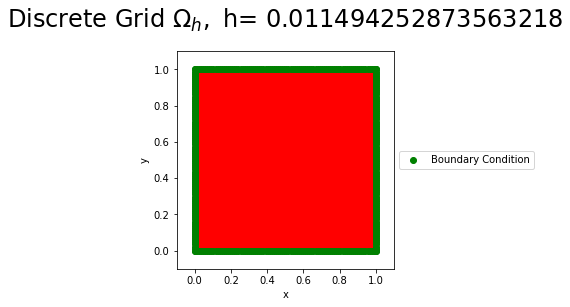

N = 88, h = 0.01149 ---->  error = 1.8583172717726014e-05


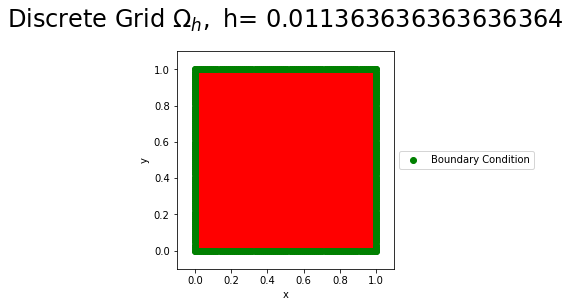

N = 89, h = 0.01136 ---->  error = 1.8165408566531e-05


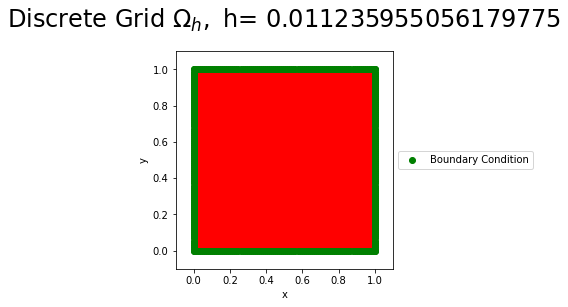

N = 90, h = 0.01124 ---->  error = 1.7757606183798086e-05


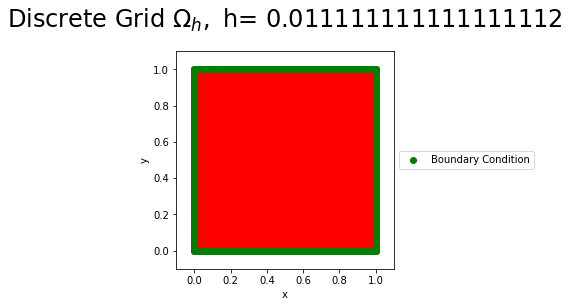

N = 91, h = 0.01111 ---->  error = 1.7366075959643604e-05


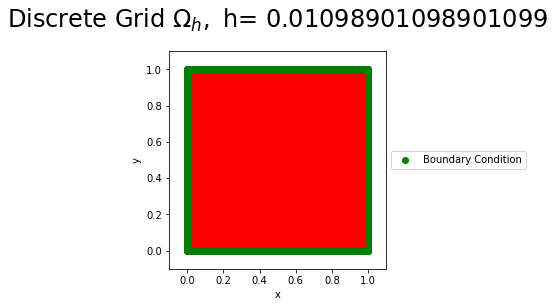

N = 92, h = 0.01099 ---->  error = 1.6986035231970414e-05


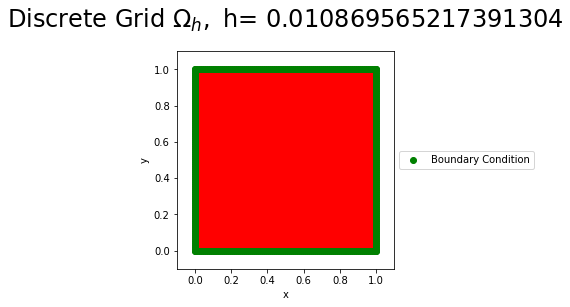

N = 93, h = 0.01087 ---->  error = 1.6616401885773976e-05


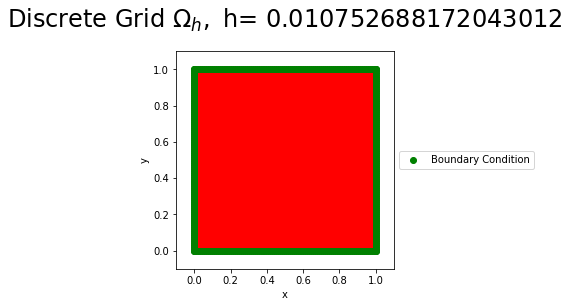

N = 94, h = 0.01075 ---->  error = 1.6261056025428365e-05


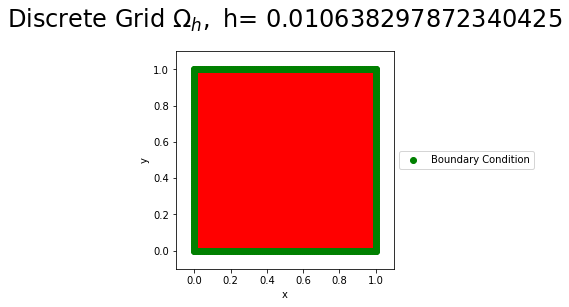

N = 95, h = 0.01064 ---->  error = 1.5918519705174338e-05


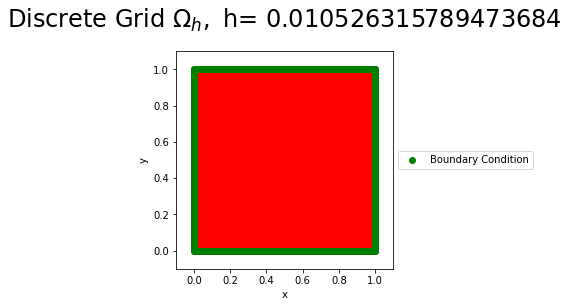

N = 96, h = 0.01053 ---->  error = 1.5583388791667375e-05


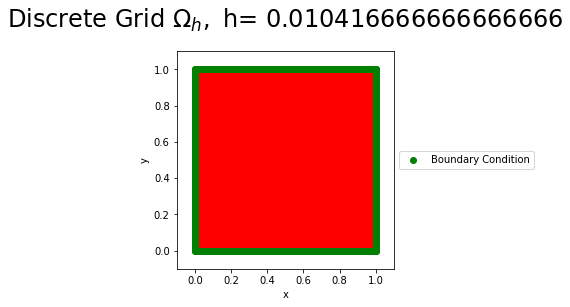

N = 97, h = 0.01042 ---->  error = 1.525695460832026e-05


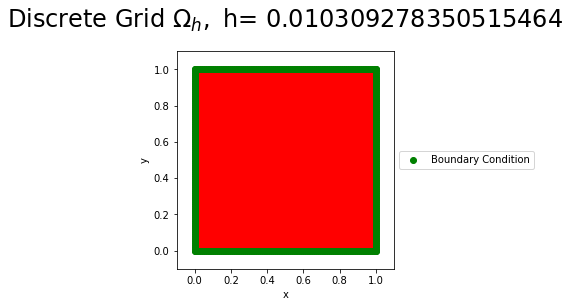

N = 98, h = 0.01031 ---->  error = 1.4949321782532496e-05


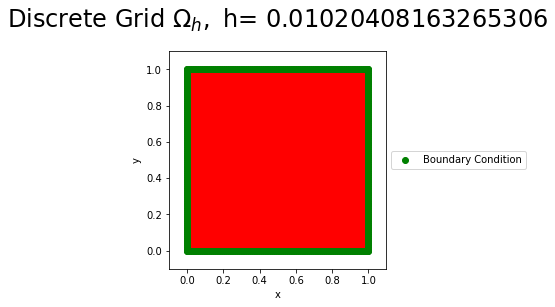

N = 99, h = 0.01020 ---->  error = 1.4642424903623094e-05


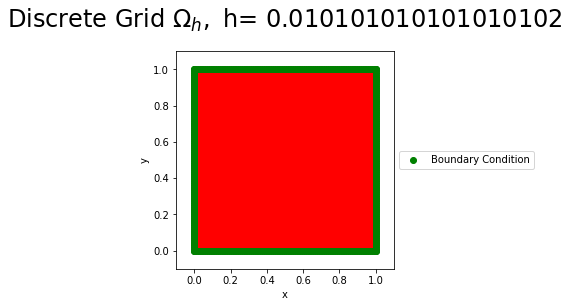

N = 100, h = 0.01010 ---->  error = 1.4345339384942459e-05


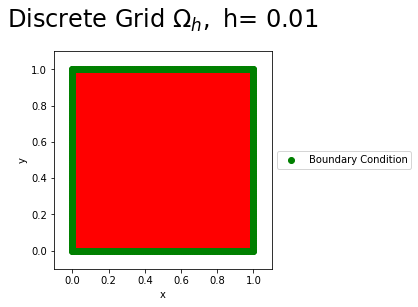

N = 101, h = 0.01000 ---->  error = 1.4063510429431876e-05


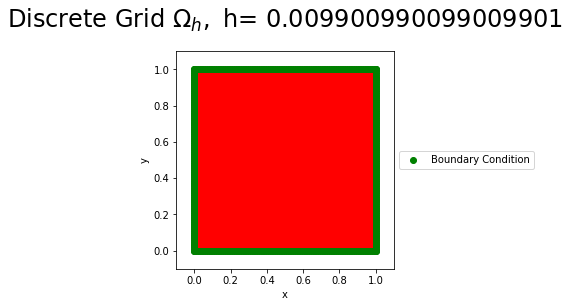

N = 102, h = 0.00990 ---->  error = 1.3785381237597529e-05


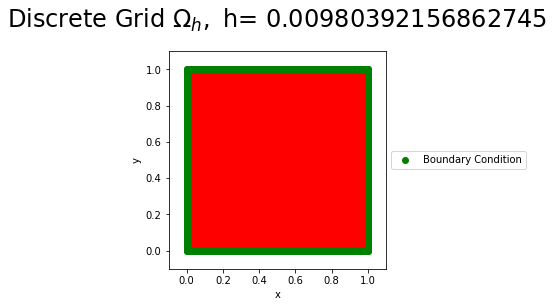

N = 103, h = 0.00980 ---->  error = 1.3513881186399916e-05


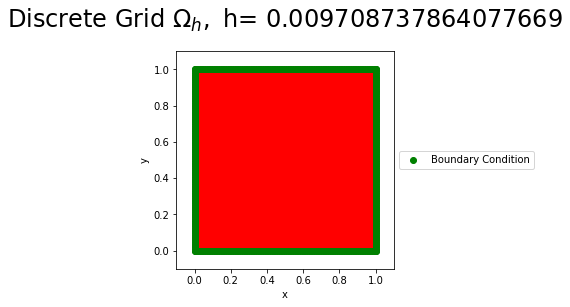

N = 104, h = 0.00971 ---->  error = 1.3252610284932518e-05


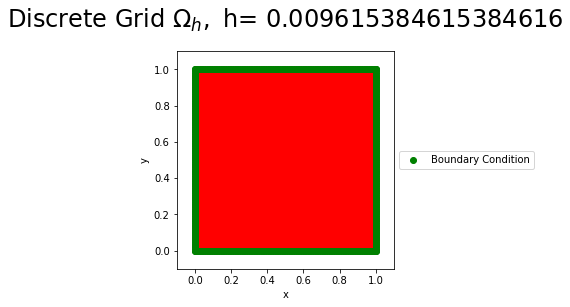

N = 105, h = 0.00962 ---->  error = 1.3001108882253597e-05


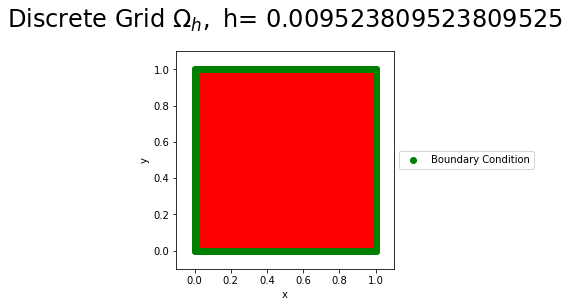

N = 106, h = 0.00952 ---->  error = 1.2751865081608145e-05


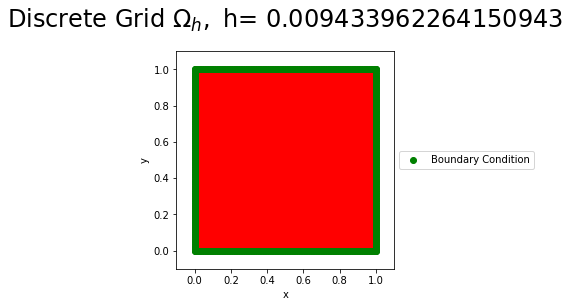

N = 107, h = 0.00943 ---->  error = 1.2516234183052499e-05


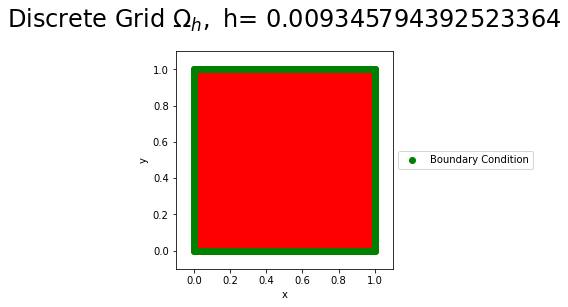

N = 108, h = 0.00935 ---->  error = 1.228321258720009e-05


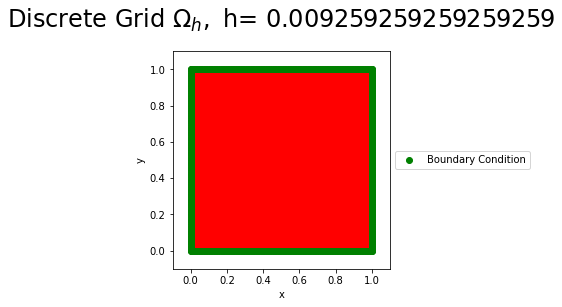

N = 109, h = 0.00926 ---->  error = 1.2053325334404383e-05


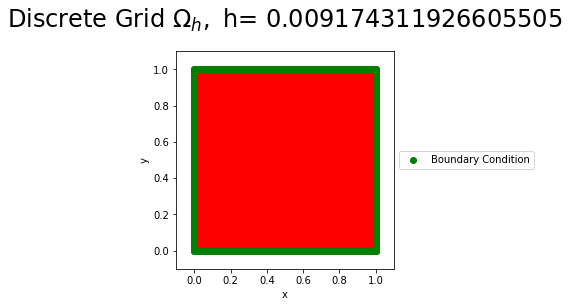

N = 110, h = 0.00917 ---->  error = 1.183110361691573e-05


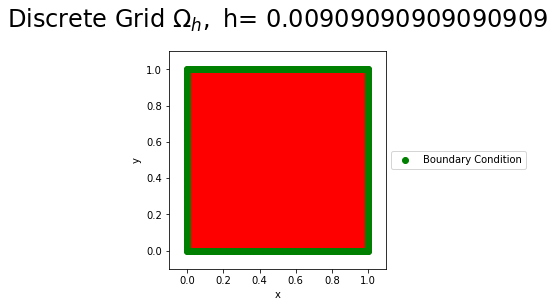

N = 111, h = 0.00909 ---->  error = 1.1622492683729234e-05


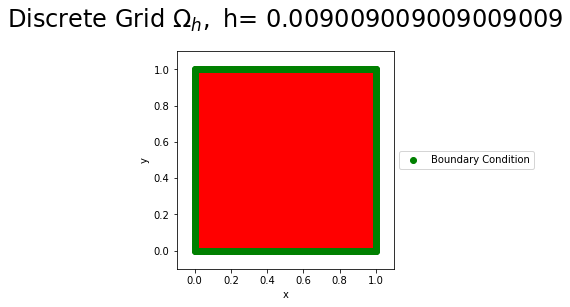

N = 112, h = 0.00901 ---->  error = 1.1412839420987682e-05


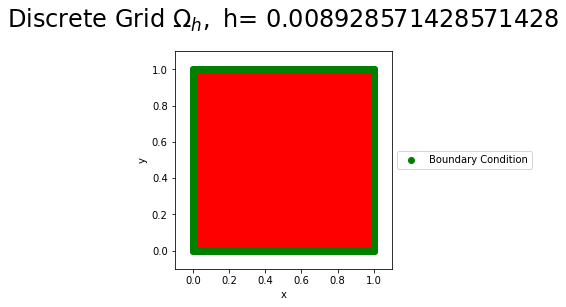

N = 113, h = 0.00893 ---->  error = 1.1205309261135345e-05


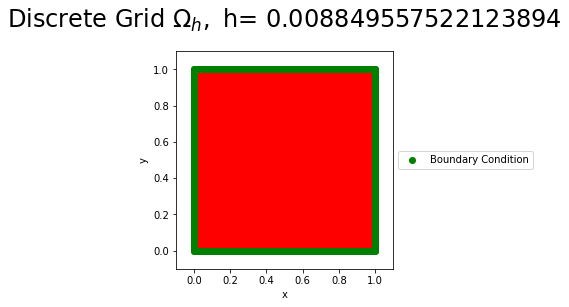

N = 114, h = 0.00885 ---->  error = 1.1006446983094471e-05


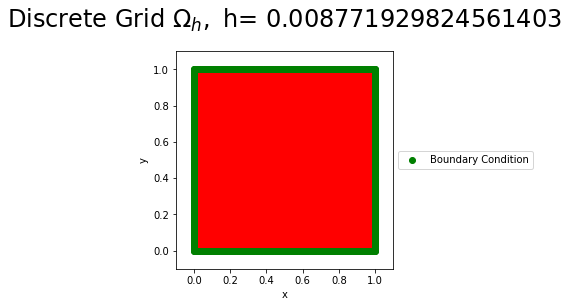

N = 115, h = 0.00877 ---->  error = 1.082275673592129e-05


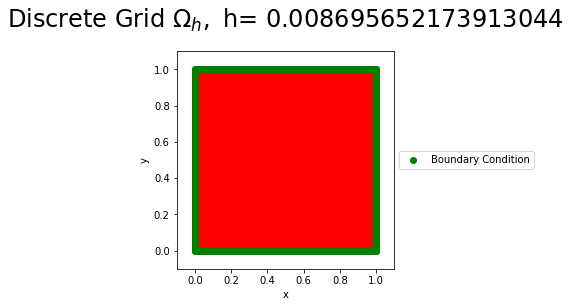

N = 116, h = 0.00870 ---->  error = 1.0631039546089589e-05


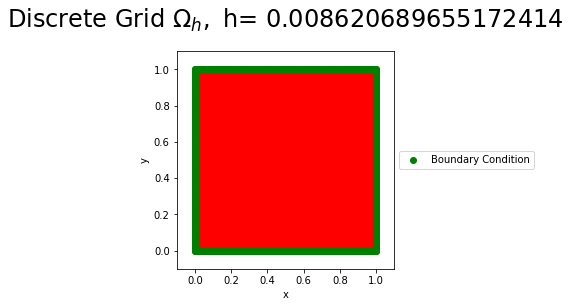

N = 117, h = 0.00862 ---->  error = 1.0443605586506627e-05


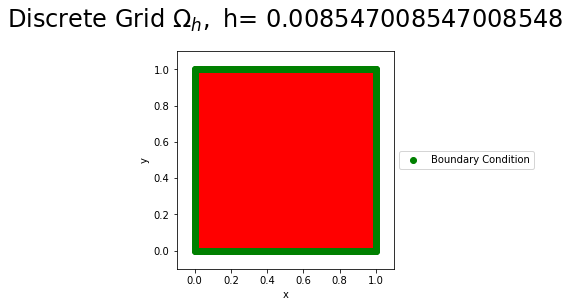

N = 118, h = 0.00855 ---->  error = 1.0300710713823218e-05


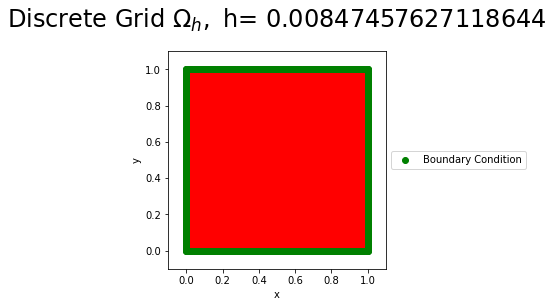

N = 119, h = 0.00847 ---->  error = 1.0092695564312256e-05


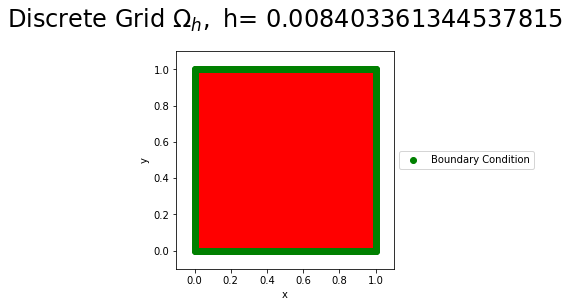

N = 120, h = 0.00840 ---->  error = 9.939855008984144e-06


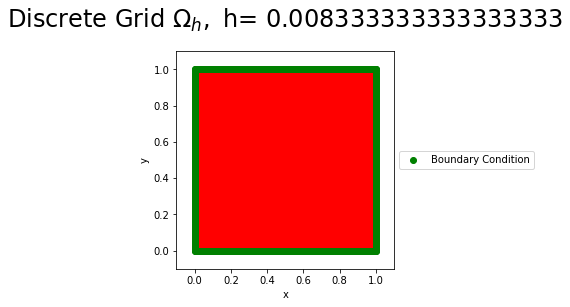

N = 121, h = 0.00833 ---->  error = 9.753271686339289e-06


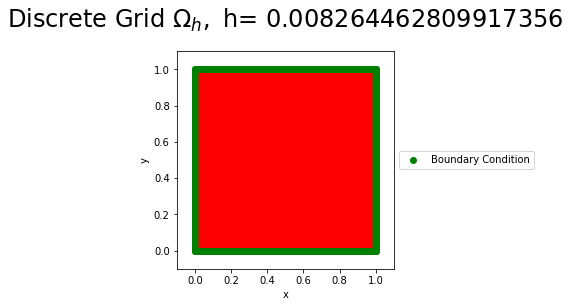

N = 122, h = 0.00826 ---->  error = 9.582336302072369e-06


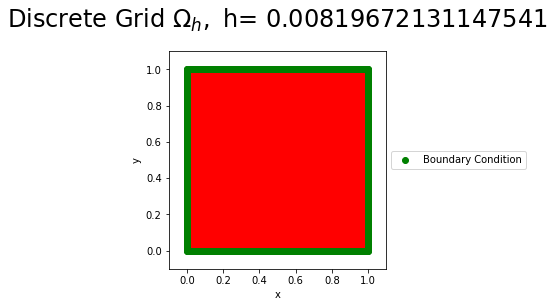

N = 123, h = 0.00820 ---->  error = 9.446357150782016e-06


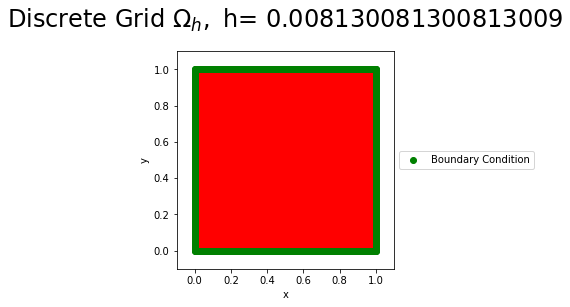

N = 124, h = 0.00813 ---->  error = 9.285590695414828e-06


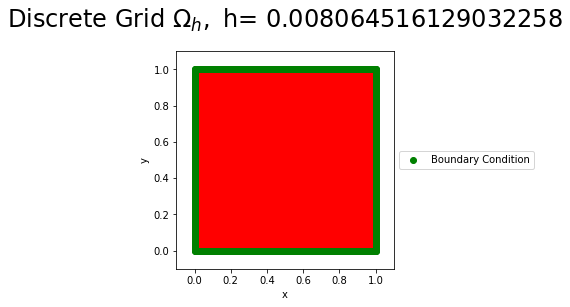

N = 125, h = 0.00806 ---->  error = 9.1594762192094e-06


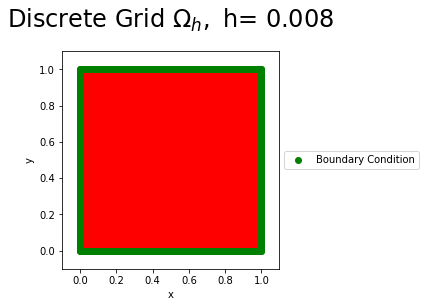

N = 126, h = 0.00800 ---->  error = 8.99570993013767e-06


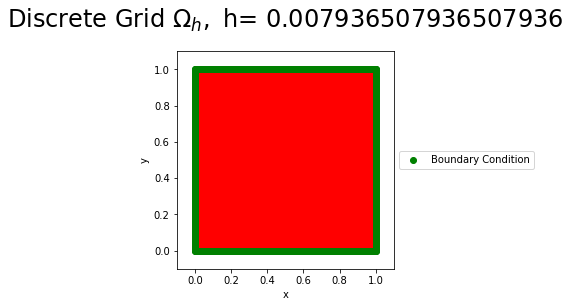

N = 127, h = 0.00794 ---->  error = 8.854248551583077e-06


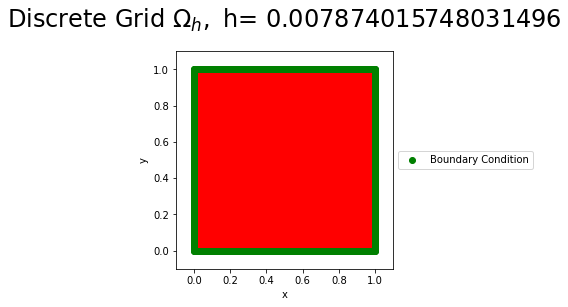

N = 128, h = 0.00787 ---->  error = 8.736756329159313e-06


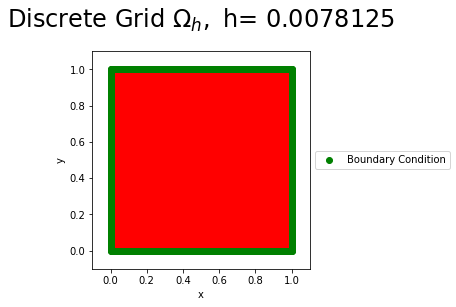

N = 129, h = 0.00781 ---->  error = 8.559754572338998e-06


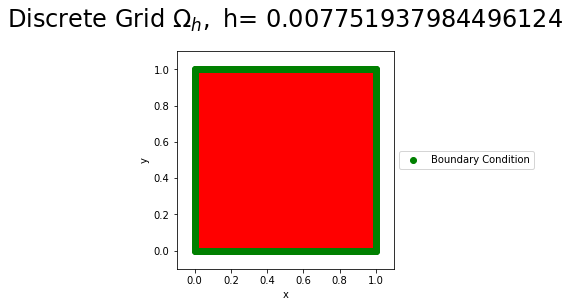

N = 130, h = 0.00775 ---->  error = 8.453209939343366e-06


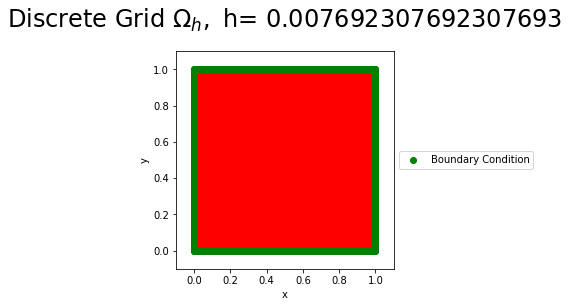

N = 131, h = 0.00769 ---->  error = 8.31441673743592e-06


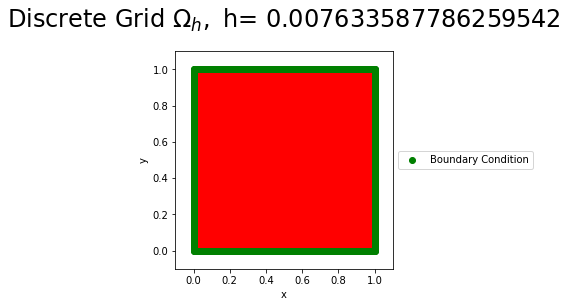

N = 132, h = 0.00763 ---->  error = 8.205468765377843e-06


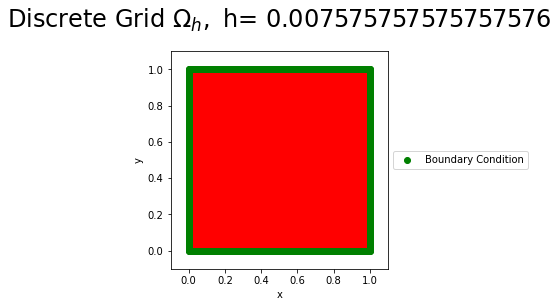

N = 133, h = 0.00758 ---->  error = 8.110928078857767e-06


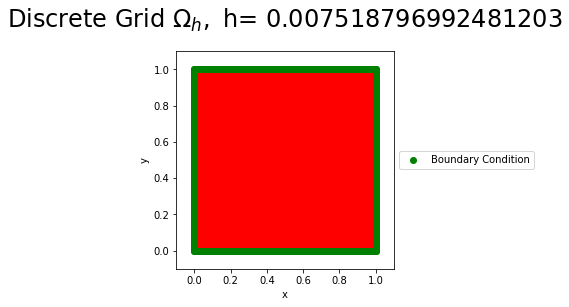

N = 134, h = 0.00752 ---->  error = 7.942791937807842e-06


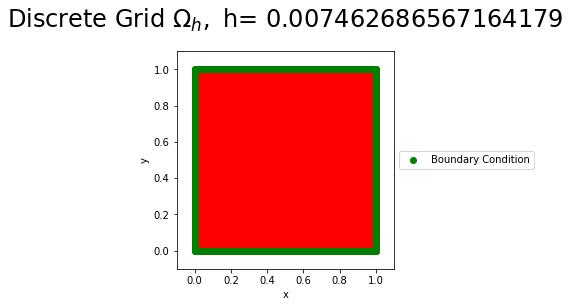

N = 135, h = 0.00746 ---->  error = 7.814652189466505e-06


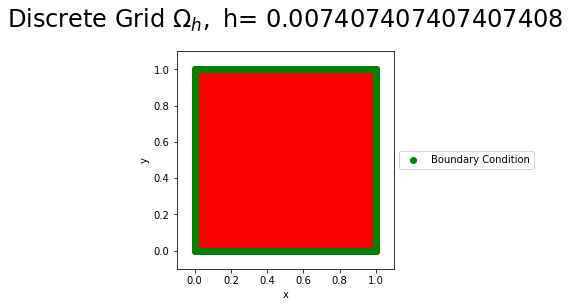

N = 136, h = 0.00741 ---->  error = 7.730665449218085e-06


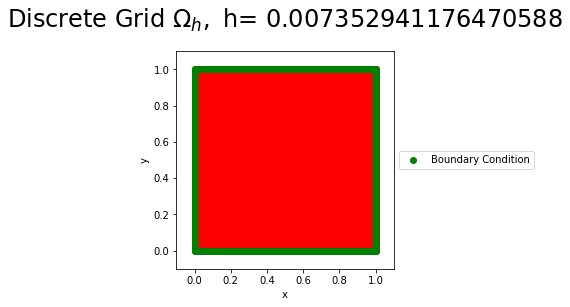

N = 137, h = 0.00735 ---->  error = 7.667998217418817e-06


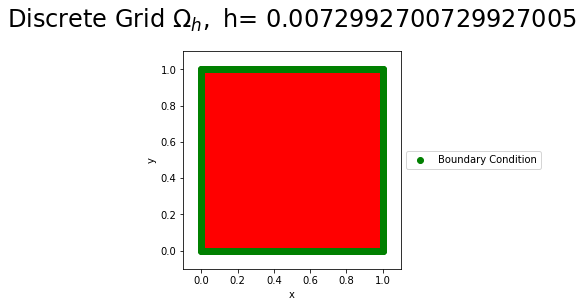

N = 138, h = 0.00730 ---->  error = 7.5105160141571045e-06


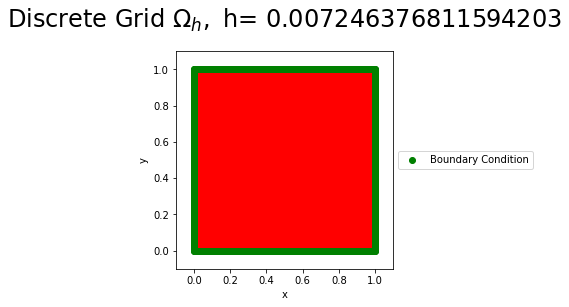

N = 139, h = 0.00725 ---->  error = 7.432111643585077e-06


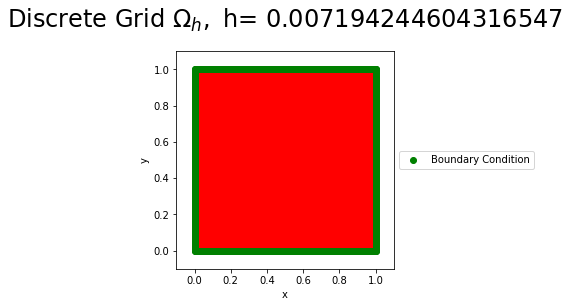

N = 140, h = 0.00719 ---->  error = 7.294349305603207e-06


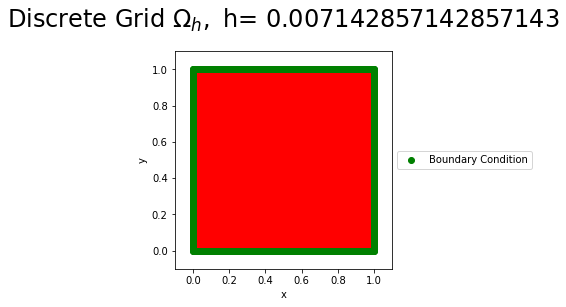

N = 141, h = 0.00714 ---->  error = 7.250566589829602e-06


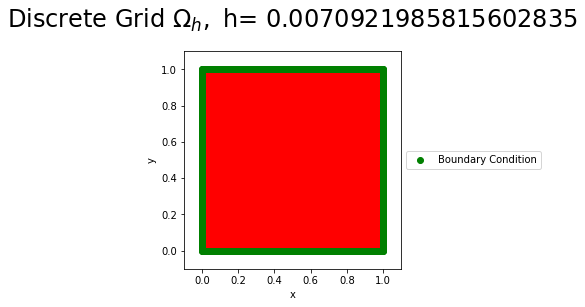

N = 142, h = 0.00709 ---->  error = 7.0970733580799975e-06


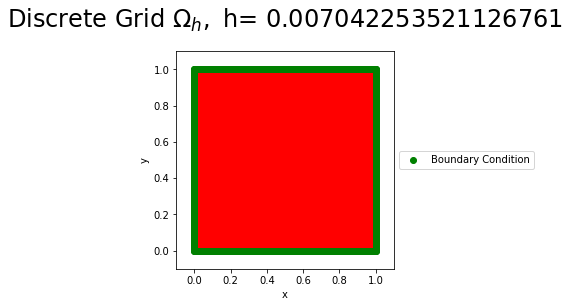

N = 143, h = 0.00704 ---->  error = 6.969001371629244e-06


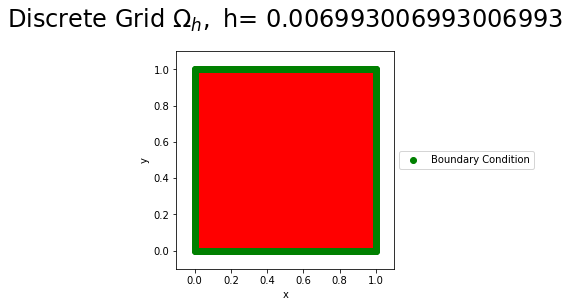

N = 144, h = 0.00699 ---->  error = 6.8545081507150545e-06


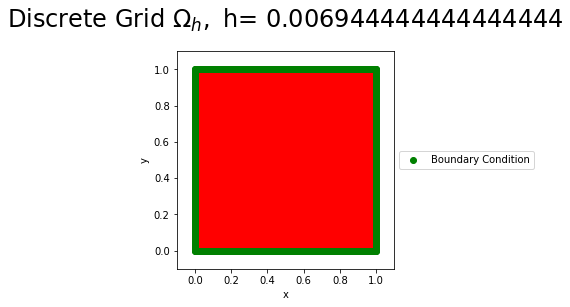

N = 145, h = 0.00694 ---->  error = 6.760201769594976e-06


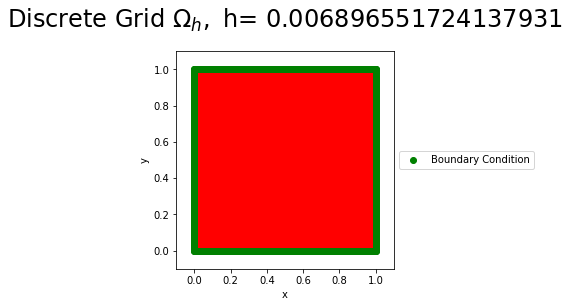

N = 146, h = 0.00690 ---->  error = 6.789035105058344e-06


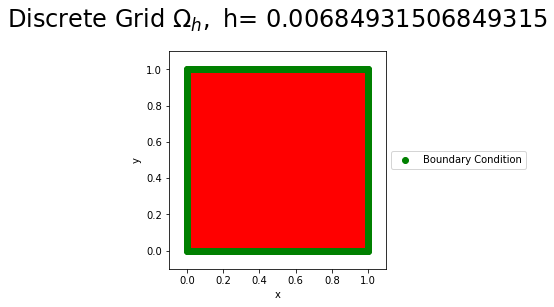

N = 147, h = 0.00685 ---->  error = 6.778939334731146e-06


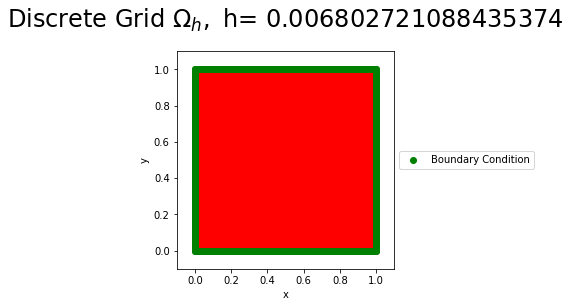

N = 148, h = 0.00680 ---->  error = 6.528376838840649e-06


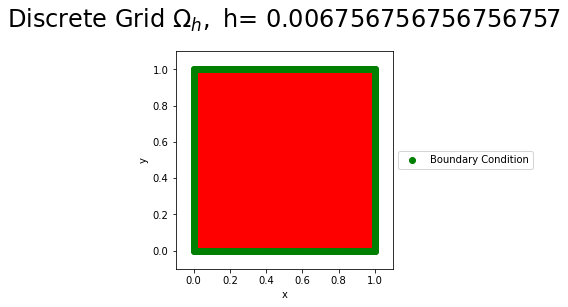

N = 149, h = 0.00676 ---->  error = 6.4575505303997815e-06


(array([[-87616.,  21904.,      0., ...,      0.,      0.,      0.],
        [ 21904., -87616.,  21904., ...,      0.,      0.,      0.],
        [     0.,  21904., -87616., ...,      0.,      0.,      0.],
        ...,
        [     0.,      0.,      0., ..., -87616.,  21904.,      0.],
        [     0.,      0.,      0., ...,  21904., -87616.,  21904.],
        [     0.,      0.,      0., ...,      0.,  21904., -87616.]]),
 array([[-4.65339674e+02],
        [-4.18594765e-01],
        [-4.18123040e-01],
        ...,
        [ 4.18123040e-01],
        [ 4.18594765e-01],
        [ 4.65339674e+02]]),
 array([[0.       , 1.       ],
        [0.25     , 1.       ],
        [0.5      , 1.       ],
        ...,
        [0.9864865, 0.       ],
        [0.9932432, 0.       ],
        [1.       , 0.       ]], dtype=float32),
 [0.00849468841846562,
  0.005548493973057103,
  0.003881293068467036,
  0.0028605314826323906,
  0.002193459315132806,
  0.0017345303949222964,
  0.0014056349480316343,
  

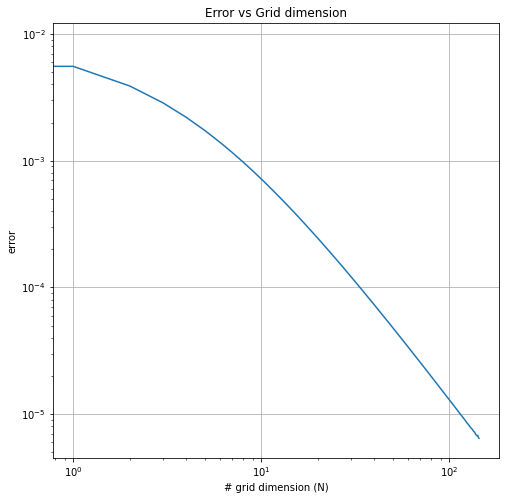

In [19]:
main(5,150)